In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import polars as pl
from scipy import stats
from scipy.stats import bootstrap

In [3]:
def compute_mean(data, name):
    mean = np.mean(data)
    std = np.std(data, ddof=1)            # sample standard deviation
    n = len(data)
    #sem = std / np.sqrt(n)
    sem = stats.sem(data)   # standard error of the mean
    # 95% confidence interval assuming normality:
    res = bootstrap((data,), np.mean, confidence_level=0.95, n_resamples=10000, method='BCa')
    ci_low = res.confidence_interval.low
    ci_high = res.confidence_interval.high
    print(f"{name}: mean={mean:.3f}, std={std:.3f}, se={sem:.3f}, 95% CI=({ci_low:.3f}, {ci_high:.3f})")
    return [mean, std, sem, ci_low, ci_high]

In [4]:
df_special = pl.read_csv("special.csv", separator=",")*100
# print(df)
robots = ["Bez1", "OP3 Rot", "Bez2", "Bez3", "Sigmaban", "Wolfgang", "Nugus"]

special_data = []  # mean, std, sem, ci_low, ci_high
for name in robots:
    special_data.append(compute_mean(df_special[name].to_list(), f"Specialized {name}"))
special_data = np.array(special_data)

Specialized Bez1: mean=70.700, std=41.368, se=13.082, 95% CI=(41.900, 90.000)
Specialized OP3 Rot: mean=91.400, std=1.174, se=0.371, 95% CI=(90.700, 92.100)
Specialized Bez2: mean=97.800, std=0.422, se=0.133, 95% CI=(97.400, 98.000)
Specialized Bez3: mean=94.700, std=0.483, se=0.153, 95% CI=(94.400, 94.900)
Specialized Sigmaban: mean=95.700, std=12.579, se=3.978, 95% CI=(80.000, 100.000)
Specialized Wolfgang: mean=92.500, std=0.972, se=0.307, 95% CI=(91.600, 92.900)
Specialized Nugus: mean=9.300, std=29.060, se=9.189, 95% CI=(0.000, 46.098)


In [9]:
df_loo = pl.read_csv("loo.csv", separator=",")
# print(df)
robots = ["Bez1", "OP3 Rot", "Bez2", "Bez3", "Sigmaban", "Wolfgang", "Nugus"]
df_dict = {}
count = 0
for chunk in df_loo.iter_slices(n_rows=10):
    df_dict[robots[count]] = chunk*100
    count += 1
def p_to_star(p):
    # if p < 0.001:
    #     return '***'
    # elif p < 0.01:
    #     return '**'
    if p < 0.05:
        return '*'

loo_data = [] # mean, std, sem, ci_low, ci_high, p_val
for name in robots:
    tmp = []
    for name2 in robots:
        t_stat, p_val = stats.ttest_ind(df_dict[name][name2].to_list(), df_special[name2].to_list(), equal_var=False)
        t = compute_mean(df_dict[name][name2].to_list(), f"LOO {name} out, test on {name2}")
        t.append(p_val)
        tmp.append(t)
    loo_data.append(tmp)
loo_data = np.array(loo_data)
loo_data[:,:,0]

# for name in robots:
#     t_stat, p_val = stats.ttest_ind(df_dict["Wolfgang"][name].to_list(), df_special[name].to_list(), equal_var=False)
#     print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.6f}")
#     p_vals.append(p_val)
# tmp = []
# for name in robots:
#     if name == "Nugus":
#         break
#     tmp.append(df_dict[name]["Nugus"].to_list())
# tmp = np.array(tmp).flatten()
# t = compute_mean(tmp, f"LOO {1} out, test on {2}")



LOO Bez1 out, test on Bez1: mean=20.100, std=17.578, se=5.559, 95% CI=(12.200, 33.700)
LOO Bez1 out, test on OP3 Rot: mean=57.800, std=26.582, se=8.406, 95% CI=(40.500, 72.100)
LOO Bez1 out, test on Bez2: mean=55.100, std=19.991, se=6.322, 95% CI=(45.400, 69.400)
LOO Bez1 out, test on Bez3: mean=75.400, std=14.886, se=4.707, 95% CI=(64.900, 82.700)
LOO Bez1 out, test on Sigmaban: mean=82.700, std=23.229, se=7.346, 95% CI=(62.700, 93.200)
LOO Bez1 out, test on Wolfgang: mean=87.700, std=10.688, se=3.380, 95% CI=(76.800, 91.500)
LOO Bez1 out, test on Nugus: mean=78.700, std=16.385, se=5.181, 95% CI=(65.010, 85.900)
LOO OP3 Rot out, test on Bez1: mean=8.300, std=12.157, se=3.844, 95% CI=(2.900, 18.800)
LOO OP3 Rot out, test on OP3 Rot: mean=35.300, std=16.526, se=5.226, 95% CI=(25.500, 44.700)
LOO OP3 Rot out, test on Bez2: mean=69.200, std=25.468, se=8.054, 95% CI=(54.200, 83.500)
LOO OP3 Rot out, test on Bez3: mean=73.800, std=27.466, se=8.686, 95% CI=(54.900, 86.100)
LOO OP3 Rot out, t

array([[20.1, 57.8, 55.1, 75.4, 82.7, 87.7, 78.7],
       [ 8.3, 35.3, 69.2, 73.8, 87.9, 89.2, 85.9],
       [11.7, 45.4, 34.1, 77.9, 85.2, 91.1, 82.1],
       [27.8, 66.4, 65.5, 17.3, 89.2, 90. , 82. ],
       [47. , 63.4, 66.8, 84.4, 41.9, 92.1, 86.1],
       [57.5, 80.3, 80. , 86.6, 90.4, 72.5, 70.7],
       [52. , 69.1, 78.8, 82. , 93. , 88.9, 33.7]])

In [32]:
from scipy import stats
from scipy.stats import bootstrap

returns_specialist = [0.38,
0.97,
0.00,
0.95,
0.96]
returns_shared = [
    0.92,
0.90,
0.66,
0.82,
0.57,

]
def compute_mean(data, name):
    mean = np.mean(data)
    std = np.std(data, ddof=1)            # sample standard deviation
    n = len(data)
    #sem = std / np.sqrt(n)
    sem = stats.sem(data)   # standard error of the mean
    # 95% confidence interval assuming normality:
    res = bootstrap((returns_specialist,), np.mean, confidence_level=0.95, n_resamples=10000, method='BCa')
    ci_low = res.confidence_interval.low
    ci_high = res.confidence_interval.high
    print(f"{name}: mean={mean:.3f}, std={std:.3f}, se={sem:.3f}, 95% CI=({ci_low:.3f}, {ci_high:.3f})")
    return mean, std, sem, ci_low, ci_high

compute_mean(returns_specialist, "Specialist")
compute_mean(returns_shared, "Shared")

res = bootstrap((returns_specialist,), np.mean, confidence_level=0.95, n_resamples=10000, method='BCa')
print(f"Specialist 95% CI from scipy.bootstrap: {res.confidence_interval.low:.3f},{res.confidence_interval.high:.3f}")
res = bootstrap((returns_shared,), np.mean, confidence_level=0.95, n_resamples=10000, method='BCa')
print(f"Shared 95% CI from scipy.bootstrap: {res.confidence_interval.low:.3f},{res.confidence_interval.high:.3f}")



t_stat, p_val = stats.ttest_ind(returns_shared, returns_specialist, equal_var=False)
print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.3f}")


# bootstrap-based power analysis
from statsmodels.stats.power import TTestIndPower

pooled_sd     = 0.05
delta         = 0.12                    # expected absolute difference
effect_size   = delta / pooled_sd          # Cohen's d
analysis      = TTestIndPower()

n_per_group = analysis.solve_power(effect_size=effect_size,
                                   alpha=0.05, power=0.80, ratio=1.0)

print(f"Need ≈ {np.ceil(n_per_group):.0f} seeds per condition for 80 % power.")



Specialist: mean=0.65, std=0.44, se=0.20, 95% CI=(0.26, 1.04)
Shared: mean=0.77, std=0.15, se=0.07, 95% CI=(0.64, 0.91)
Specialist 95% CI from scipy.bootstrap: 0.266,0.960
Shared 95% CI from scipy.bootstrap: 0.638,0.880
t-statistic = 0.582, p-value = 0.586
Need ≈ 4 seeds per condition for 80 % power.


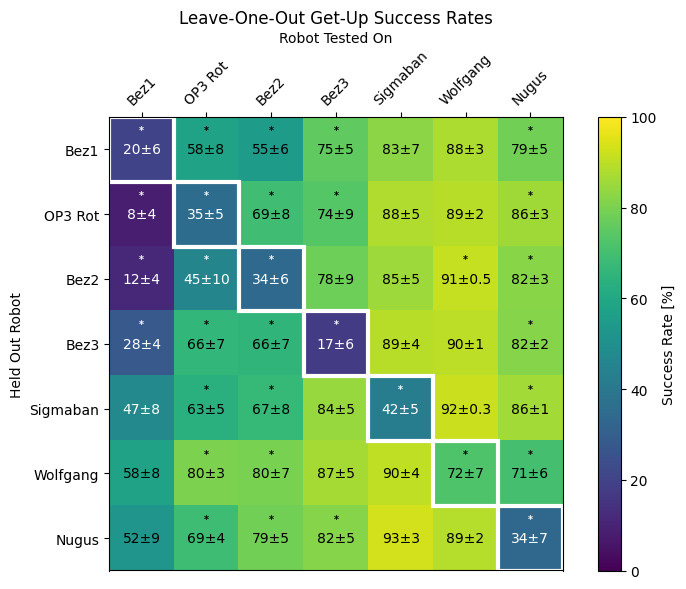

In [10]:

# Data from the LOO experiment
robots = ["Bez1", "OP3 Rot", "Bez2", "Bez3", "Sigmaban", "Wolfgang", "Nugus"]


fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(loo_data[:,:,0], cmap='viridis', vmin=0, vmax=100)
ax.xaxis.tick_top()             # move x‑axis ticks to the top
ax.xaxis.set_label_position('top')  # move the x‑axis label as well
# Set ticks and labels
ax.set_xticks(np.arange(len(robots)))
ax.set_yticks(np.arange(len(robots)))
ax.set_xticklabels(robots)
ax.set_yticklabels(robots)
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

# Annotate cells with values
for i in range(len(robots)):
    for j in range(len(robots)):
        if int(loo_data[i,j,2]) == 0:
            ax.text(j, i, f"{loo_data[i,j,0]:.0f}±{loo_data[i,j,2]:.1f}", ha="center", va="center",
                color="w" if loo_data[i,j,0] < 50 else "black")#, fontsize=8)
        else:
            ax.text(j, i, f"{loo_data[i,j,0]:.0f}±{loo_data[i,j,2]:.0f}", ha="center", va="center",
                    color="w" if loo_data[i,j,0] < 50 else "black")#, fontsize=8)


for i in range(len(robots)):
    for j in range(len(robots)):
        p_val = loo_data[i,j,-1]
        star = p_to_star(p_val)
        # We determine the vertical offset so that it sits above the "mean±sem" line.
        # Using va='bottom' will anchor the bottom of the star text at (j, i + offset).
        # Here 0.3 is an empirically chosen offset; adjust if needed.
        ax.text(
            j, i - 0.225,  # x = column, y = row + offset
            star,
            ha="center", va="bottom",
            color="black" if loo_data[i, j, 0] >= 50 else "white",
            fontsize=7,
            fontweight='bold'
        )

# ─── Draw a thick white border on diagonal (zero-shot) cells ───
for i in range(len(robots)):
    rect = plt.Rectangle((i - 0.5, i - 0.5), 1, 1,
                         fill=False,
                         edgecolor='white',
                         linewidth=3)
    ax.add_patch(rect)
# Labels and colorbar
ax.set_xlabel("Robot Tested On")
ax.set_ylabel("Held Out Robot")
ax.set_title("Leave-One-Out Get-Up Success Rates")
fig.colorbar(cax, label="Success Rate [%]")
plt.tight_layout()
plt.show()
fig.savefig(
    'heatmap3.png',
    dpi=600,
    bbox_inches='tight'
)

In [244]:
special_data[:,0]
loo_data[-2,:,0]
p_vals = []
for name in robots:
    t_stat, p_val = stats.ttest_ind(df_dict["Wolfgang"][name].to_list(), df_special[name].to_list(), equal_var=False)
    print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.6f}")
    p_vals.append(p_val)
# from statsmodels.stats.multitest import multipletests
# _, p_vals_corr, _, _ = multipletests(p_vals, alpha=0.05, method="holm")
# for name in p_vals_corr:
#     print(f"p-value = {name:.6f}")

t-statistic = -0.858, p-value = 0.404391
t-statistic = -4.304, p-value = 0.001797
t-statistic = -2.686, p-value = 0.024930
t-statistic = -1.571, p-value = 0.150568
t-statistic = -0.896, p-value = 0.382444
t-statistic = -3.058, p-value = 0.013540
t-statistic = 5.470, p-value = 0.000050


he


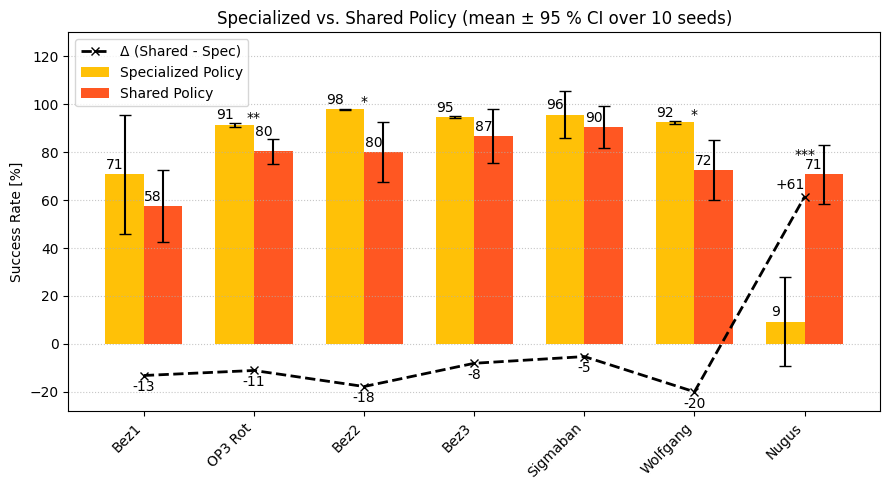

In [251]:
# Data for specialized vs. shared policy success rates
robots = ["Bez1", "OP3 Rot", "Bez2", "Bez3", "Sigmaban", "Wolfgang", "Nugus"]
specialized = special_data[:,0]
shared_best = loo_data[-2,:,0]

# Compute delta (shared - specialized)
delta = shared_best - specialized

x = np.arange(len(robots))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 5))
yerr_spec   = (special_data[:,-1]   - special_data[:,-2])   / 2
yerr_shared = (loo_data[-2,:,-2]   - loo_data[-2,:,-3]) / 2

# Plot grouped bars
bar1 = ax.bar(x - width/2, specialized,
              width, yerr=yerr_spec, capsize=4,
              label='Specialized Policy', color='#FFC107')
bar2 = ax.bar(x + width/2, shared_best,
              width, yerr=yerr_shared, capsize=4,
              label='Shared Policy',      color='#FF5722')

# Plot delta as a dashed line with markers
ax.plot(x, delta, marker='x', color='black', linestyle='--', linewidth=2, label='Δ (Shared - Spec)', zorder=5)
# ---------- 3.  Significance stars ----------
def p_to_star(p):
    if   p < 0.001: return '***'
    elif p < 0.01:  return '**'
    elif p < 0.05:  return '*'

for i, p in enumerate(p_vals):
    star = p_to_star(p)
    max_bar = max(bar1[i].get_height(), bar2[i].get_height())
    if star == '***':
        ax.text(x[i], max_bar + 5, star, ha='center', va='bottom', fontsize=10)
    else:
        ax.text(x[i], max_bar + 0.08, star, ha='center', va='bottom', fontsize=10)

# Labels and title
ax.set_xticks(x)
ax.set_xticklabels(robots, rotation=45, ha="right")
ax.set_ylabel('Success Rate [%]')
ax.set_title('Specialized vs. Shared Policy (mean ± 95 % CI over 10 seeds)')
ax.set_ylim(-28, 130)

# Annotate bar heights
for bar in bar1+bar2:
    height = bar.get_height()
    if height == 80.3:
        print("he")
        ax.text(bar.get_x() + bar.get_width()/2-0.09, height + 5, f"{height:.0f}", ha='center', va='bottom')
    else:
        ax.text(bar.get_x() + bar.get_width()/2-0.09, height + 1, f"{height:.0f}", ha='center', va='bottom')
# for bar in bar2:
#     height = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width()/2+0.1, height + 0.03, f"{height:.0f}", ha='center', va='bottom')
# Annotate delta points
for xi, d in zip(x, delta):
    va = 'bottom' if d >= 0 else 'top'
    offset = 2 if d >= 0 else -2
    offset2 = 0.13 if d == 61.400000000000006 else 0
    # offset3 = -0.05 if d == 61.4 else 0
    ax.text(xi-offset2, d + offset + offset3, f"{d:+.0f}", ha='center', va=va)

# Legend and grid
ax.legend(loc='upper left')
ax.grid(axis='y', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()
fig.savefig(
    'special.png',
    dpi=600,
    bbox_inches='tight'
)

In [11]:
bb_morph = pl.read_csv("s3_bb.csv", separator=",")*100
# print(df)
robots = ["Bez1", "OP3 Rot", "Bez2", "Bez3", "Sigmaban", "Wolfgang", "Nugus"]

bb_morph_data = []  # mean, std, sem, ci_low, ci_high, pval
def p_to_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'

for name in ['1','2','3','4','5','6','7']:
    t_stat, p_val = stats.ttest_ind(bb_morph[name].to_list(), df_special["Wolfgang"].to_list(), equal_var=False)
    t = compute_mean(bb_morph[name].to_list(), f"Specialized {name}")
    print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.10f}")
    t.append(p_val)
    bb_morph_data.append(t)

bb_morph_data = np.array(bb_morph_data)
# t_stat, p_val = stats.ttest_ind(df_morph['5'].to_list(), df_morph['4'].to_list(), equal_var=False)
# print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.10f}")

#TODO replace init case

Specialized 1: mean=37.100, std=16.162, se=5.111, 95% CI=(27.700, 46.200)
t-statistic = -10.820, p-value = 0.0000017444
Specialized 2: mean=68.000, std=22.236, se=7.032, 95% CI=(54.200, 80.600)
t-statistic = -3.481, p-value = 0.0068884803
Specialized 3: mean=71.600, std=18.295, se=5.785, 95% CI=(60.200, 81.400)
t-statistic = -3.607, p-value = 0.0056297313
Specialized 4: mean=15.000, std=19.494, se=6.164, 95% CI=(6.000, 29.858)
t-statistic = -12.557, p-value = 0.0000004992
Specialized 5: mean=85.800, std=6.596, se=2.086, 95% CI=(80.900, 89.000)
t-statistic = -3.178, p-value = 0.0106479009
Specialized 6: mean=81.900, std=14.851, se=4.696, 95% CI=(69.981, 88.700)
t-statistic = -2.252, p-value = 0.0505698998
Specialized 7: mean=72.500, std=20.657, se=6.532, 95% CI=(57.600, 82.400)
t-statistic = -3.058, p-value = 0.0135404424


In [12]:
df_morph = pl.read_csv("s3.csv", separator=",")*100
# print(df)
robots = ["Bez1", "OP3 Rot", "Bez2", "Bez3", "Sigmaban", "Wolfgang", "Nugus"]

sig_morph_data = []  # mean, std, sem, ci_low, ci_high, pval
def p_to_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'

for name in ['1','2','3','4','5','6','7']:
    t_stat, p_val = stats.ttest_ind(df_morph[name].to_list(), df_special["Wolfgang"].to_list(), equal_var=False)
    t = compute_mean(df_morph[name].to_list(), f"Specialized {name}")
    print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.10f}")
    t.append(p_val)
    sig_morph_data.append(t)

sig_morph_data = np.array(sig_morph_data)

Specialized 1: mean=2.900, std=3.843, se=1.215, 95% CI=(1.400, 6.700)
t-statistic = -71.483, p-value = 0.0000000000
Specialized 2: mean=12.500, std=21.319, se=6.742, 95% CI=(2.400, 30.300)
t-statistic = -11.854, p-value = 0.0000008236
Specialized 3: mean=40.100, std=11.020, se=3.485, 95% CI=(33.500, 46.400)
t-statistic = -14.979, p-value = 0.0000000966
Specialized 4: mean=6.900, std=10.535, se=3.331, 95% CI=(2.000, 15.400)
t-statistic = -25.586, p-value = 0.0000000008
Specialized 5: mean=39.500, std=11.521, se=3.643, 95% CI=(32.300, 45.900)
t-statistic = -14.497, p-value = 0.0000001307
Specialized 6: mean=46.200, std=18.341, se=5.800, 95% CI=(37.600, 60.300)
t-statistic = -7.972, p-value = 0.0000220370
Specialized 7: mean=41.900, std=14.813, se=4.684, 95% CI=(34.300, 51.700)
t-statistic = -10.779, p-value = 0.0000017820


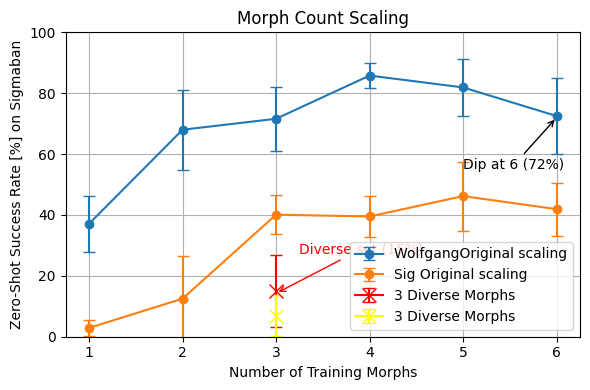

In [14]:
# Base Morph Count Scaling data
training_counts = [1, 2, 3,4, 5, 6]
success_rates = bb_morph_data[:,0].copy()
diverse_success = success_rates[3]
success_rates= np.delete(success_rates,3)
# success_rates= np.delete(success_rates,1)
yerr   = (bb_morph_data[:,-2]   - bb_morph_data[:,-3])   / 2
yerr_diverse = yerr[3]

yerr = np.delete(yerr,3)
# yerr = np.delete(yerr,1)

sig_success_rates = sig_morph_data[:,0].copy()
sig_diverse_success = sig_success_rates[3]
sig_success_rates= np.delete(sig_success_rates,3)
# sig_success_rates= np.delete(sig_success_rates,2)
sig_yerr   = (sig_morph_data[:,-2]   - sig_morph_data[:,-3])   / 2
sig_yerr_diverse = sig_yerr[3]

sig_yerr = np.delete(sig_yerr,3)
fig, ax = plt.subplots(figsize=(6, 4))

# Plot base scaling curve
ax.errorbar(training_counts, success_rates, yerr=yerr, capsize=4, marker='o', label='WolfgangOriginal scaling')
ax.errorbar( training_counts, sig_success_rates, yerr=sig_yerr, capsize=4, marker='o', label='Sig Original scaling')
# # Annotate the dip at 5 morphs
ax.annotate('Dip at 6 (72%)', xy=(6, 72), xytext=(5, 55),
            arrowprops=dict(arrowstyle='->'))

# Add diverse-only marker at 3 morphs
ax.errorbar([3], [diverse_success], yerr=yerr_diverse, capsize=4, color='red', marker='x', ms=10, label='3 Diverse Morphs')
ax.errorbar([3], [sig_diverse_success], yerr=sig_yerr_diverse, capsize=4, color='yellow', marker='x', ms=10, label='3 Diverse Morphs')

ax.annotate('Diverse set (15%)', xy=(3, 14.25), xytext=(3.25, 27.5),
            arrowprops=dict(arrowstyle='->', color='red'), color='red')

# Formatting
ax.set_xticks(training_counts)
ax.set_xlabel('Number of Training Morphs')
ax.set_ylabel('Zero-Shot Success Rate [%] on Sigmaban')
ax.set_title('Morph Count Scaling')
ax.set_ylim(0, 100)
ax.grid(True)
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()
fig.savefig(
    'morph.png',
    dpi=600,
    bbox_inches='tight'
)

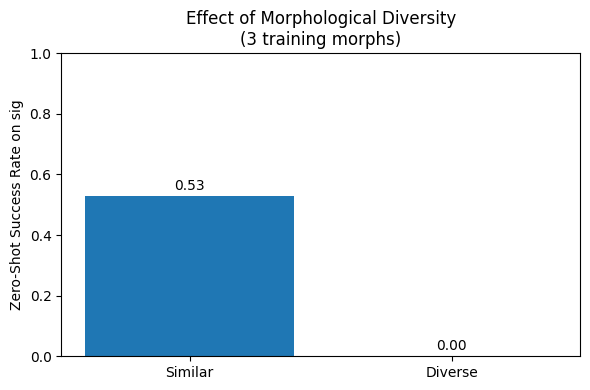

In [3]:
# Data for Similar vs. Diverse Morph experiment
conditions = ["Similar", "Diverse"]
success_rates = [0.53, 0.00]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(conditions, success_rates)
ax.set_ylim(0, 1)
ax.set_ylabel("Zero-Shot Success Rate on sig")
ax.set_title("Effect of Morphological Diversity\n(3 training morphs)")
# Annotate bars
for bar, rate in zip(bars, success_rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{rate:.2f}", ha='center')
plt.tight_layout()
plt.show()

In [6]:
# Step 1: Read the CSV file, skipping lines starting with '#'
monitor_df = pd.read_csv('/home/jonathan/catkin_ws/src/frasa/frasa_env/0.monitor.csv', comment='#')

# Step 2: Inspect the data
print("Data from monitor.csv:")
print(monitor_df.head())

# Step 3: Compute some basic statistics (e.g., average reward)
average_reward = monitor_df['r'].mean()
print("Average Reward:", average_reward)

# Step 4: Plot the rewards per episode
plt.figure(figsize=(10, 5))
plt.plot(monitor_df['t'], monitor_df['r'], label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Rewards over Time')
plt.legend()
plt.xlim(0, 2500)

plt.grid(True)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/jonathan/catkin_ws/src/frasa/frasa_env/0.monitor.csv'